In [1]:
%load_ext version_information

In [2]:
# Include version information for future reference
%version_information matplotlib, numpy, pandas, re, scipy

Software versions
Python 2.7.12 64bit [MSC v.1500 64 bit (AMD64)]
IPython 5.1.0
OS Windows 10 10.0.14393
matplotlib 1.5.3
numpy 1.11.3
pandas 0.19.1
re 2.2.1
scipy 0.19.0
Sat Apr 29 10:32:48 2017 Mountain Daylight Time

## Table of Contents
* [Import Packages](Import-Packages)
* [Read Files and Data Wrangling](Read-Files-and-Data-Wrangling) [
* [Split the Data into 4 Training Sets and 1 Test Set](Split-the-Data-into-4-Training-Sets-and-1-Test-Set)
* [Create Functions for Algorithm and Testing](Create-Functions-for-Algorithm-and-Testing)
* [Perform 5-Fold Cross Validation](Perform-5-Fold-Cross-Validation)
* [Get Parameters of Best Run](Get-Parameters-of-Best-Run)
* [Do Final Training Run](Do-Final-Training-Run)
* [Do Final Validation with Test Set](Do-Final-Validation-with-Test-Set)
* [Plot the RMSE of the Test Set Run](Plot-the-RMSE-of-the-Test-Set-Run)
* [Use Test Run Results to Print Recommendations](Use-Test-Run-Results-to-Print-Recommendations)

## Import Packages

In [3]:
%matplotlib inline

#import packages
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rnd
import re
import scipy 

from __future__ import print_function
from numpy.linalg import inv
from operator import itemgetter
from random import randrange
from scipy import linalg

## Read Files and Data Wrangling

In [4]:
# some of the movie titles were being truncated so we need to set the option for max column width to -1
pd.set_option("display.max_colwidth", -1)

In [5]:
# Read the files into pandas dataframes
ratings = pd.read_table('ml-latest-small/ratings_updated.csv', sep=',')
movies = pd.read_table('ml-latest-small/movies_updated.csv',sep=',')
tags = pd.read_table('ml-latest-small/tags.csv',sep=',')
links = pd.read_table('ml-latest-small/links.csv',sep=',')

In [6]:
# rename the timestamp columns so they have unique names
ratings.rename(columns={'timestamp': 'timestamp_ratings'}, inplace=True)
tags.rename(columns={'timestamp': 'timestamp_tags'}, inplace=True)

In [7]:
# merge the ratings, movies files into one dataframe and form the pivot table of ratings
# use dropna=False so unrated movies will also be included in the pivot table
df = pd.merge(movies, ratings, on='movieId', how='left')
pivot_table = pd.pivot_table(df, values='rating', index='userId', columns='movieId', dropna=False)

In [8]:
# create a dataframe that contains the tags with their associated movie titles and ratings(in case I want to do something with them)
# cannot merge tags directly onto the df dataframe because some users created multiple tags and there is only one entry
# per userId and movieId in df so the "extra" tags get lost
tags_movieIds = pd.merge(pd.merge(tags, movies, on='movieId', how='left'),ratings, on=['userId', 'movieId'], how= 'left')

In [9]:
# create a look up table for links associated with each movie
# will use this as a look up table to output the movie title, and a link to information on the movie when providing the recommendation
movies_links = pd.merge(movies, links)
movies_links = movies_links.set_index('movieId')

In [10]:
# use a regular expression to capture the release year from the title and put it in a column called release_date

regex = re.compile(ur"\(([\d]{4,4})\)")
movies_links['release_date'] = movies_links.title.str.extract(regex, expand=False)
# this proved to be unreliable as some of the title fields had missing dates

In [11]:
 movies_links.head()

,title,genres,imdbId,tmdbId,release_date
movieId,,,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,1995
2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0,1995
3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0,1995
4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0,1995
5,Father of the Bride Part II (1995),Comedy,113041,11862.0,1995


In [12]:
movies_links[movies_links.release_date.isnull()]

,title,genres,imdbId,tmdbId,release_date
movieId,,,,,
108548,"Big Bang Theory, The (2007-)",Comedy,898266,NaN,NaN
108583,Fawlty Towers (1975-1979),Comedy,72500,NaN,NaN
143410,Hyena Road,(no genres listed),4034452,316042.0,NaN
151307,The Lovers and the Despot,(no genres listed),5278868,373355.0,NaN
162376,Stranger Things,Drama,4574334,410612.0,NaN
164979,"Women of '69, Unboxed",Documentary,3447228,410803.0,NaN


In [13]:
# for now, quick fix the dates that regex did not capture. Look up by hand.  Later, create a web scrape script to do this.
movies_links = movies_links.set_value(108548, 'release_date', 2007)
movies_links = movies_links.set_value(108583,'release_date', 1975)
movies_links = movies_links.set_value(143410, 'release_date',2015)
movies_links = movies_links.set_value(151307, 'release_date',2015)
movies_links = movies_links.set_value(164979, 'release_date',2016)
movies_links = movies_links.set_value(162376, 'release_date',2014)

In [14]:
# check to make sure there are no more null dates
movies_links[movies_links.release_date.isnull()]

,title,genres,imdbId,tmdbId,release_date
movieId,,,,,


In [15]:
# set release_date  as type integer
movies_links['release_date'] = movies_links['release_date'].astype(np.int, copy=False)

In [16]:
# check the links columns for null data
movies_links.tmdbId.isnull().sum()

13

In [17]:

movies_links.imdbId.isnull().sum()

0

Will use the imbdId identifiers and website since there are no null values to deal with.

In [18]:
df.head()

,movieId,title,genres,userId,rating,timestamp_ratings
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,3.0,8.518667e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,9.0,4.0,9.386292e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,13.0,5.0,1.331380e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.0,9.979383e+08
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19.0,3.0,8.551901e+08


## Split the Data into 4 Training Sets and 1 Test Set

In [19]:
# create a function for dividing the pivot table into 5 pieces using userId as index for sampling
# test set should be listed last in the list of names for assignment
def assign_to_set(df, names):
    # create a column called 'Test_Group' and initialize to 'Not_Assigned'
    df['Test_Group'] = 'Not_Assigned'
    # define the size of the train groups and the one test group
    # if the size of the table does not divide evenly by 5, assign the extras to the test group
    train_size = np.int64(df.index.size/5)
    test_size = np.int64(df.index.size - 4*np.int64(df.index.size/5))
    for i, name in enumerate(names):
        # identify the ids for sampling as the ones that have not yet been assigned   
        ids_for_sampling = df[df.Test_Group == 'Not_Assigned']
        # if this is not the last set of assignments, make the size of sampled_ids equal to the train_size
        if i != 4:
            sampled_ids = np.random.choice(ids_for_sampling.index, size=train_size, replace = False)
            # make the assignment
            df.ix[sampled_ids, 'Test_Group'] = name
        # otherwise, make it equal to the test_size    
        else:
            sampled_ids = np.random.choice(ids_for_sampling.index, size=test_size, replace = False)
            # make the assignment
            df.ix[sampled_ids, 'Test_Group'] = name
    return df                               

In [20]:
# create the list of names for the test groups and then use assign_to_set function to make the assignments
names = ['train1', 'train2', 'train3', 'train4', 'test']
pivot_table = assign_to_set(pivot_table, names)

In [21]:
# Divide the pivot table into the different groups
test_set_pt = pivot_table[pivot_table.Test_Group == 'test']
train1_pt = pivot_table[pivot_table.Test_Group == 'train1']
train2_pt = pivot_table[pivot_table.Test_Group == 'train2']
train3_pt = pivot_table[pivot_table.Test_Group == 'train3']
train4_pt = pivot_table[pivot_table.Test_Group == 'train4']

In [22]:
# delete the unneeded column 'Test_Group' from each group
#Train1_df.drop('Test_Group', axis=1, inplace=True)
del pivot_table['Test_Group']
del test_set_pt['Test_Group']
del train1_pt['Test_Group']
del train2_pt['Test_Group']
del train3_pt['Test_Group']
del train4_pt['Test_Group']

## Create Functions for Algorithm and Testing

In [23]:
# Create X  and Y arrays, populate X with the mean of the user vectors and Y with mean of movie rating
# theory is that the algorithm will converge faster and give lower rmse value with fewer iterations

def create_X_Y_arrays(Q,U,I,K):
    # define the X array
    X = np.ndarray(shape = (U,K), dtype=float)

    for k in range(K): 
        for user in range(len(Q)): 
            # assign X(u,k) with the mean of Q[u]
            X[user][k] = np.nanmean(Q[user])
            
    # define the Y array
    Y = np.ndarray(shape = (K,I), dtype=float)

    for k in range(K): 
        for item in range(len(Q[user])): 
            # if item has at least 1 rating in the column, use the mean of the ratings, otherwise use a random value
            if np.isnan(Q[:,[item]]).any() != True:
                Y[k][item] = np.nanmean(Q[:,[item]])
            else:
                Y[k][item] = 5 * np.random.random()
    return X,Y                     

In [24]:
#create the W matrix which has a '1' in all spots where Q has ratings and a '0' in spots with 'Nan' or no ratings.
# by doing this before changing nans to zeroes in Q, we preserve the true rating values of 0, if there are any

def create_W(Q):
    W=copy.deepcopy(Q)
    W[W == 0] = 1
    W = np.nan_to_num(W)
    W[W > 0] = 1
    return W

In [25]:
# compute the root mean squared error for each corresponding value in the Q and Q_hat matrices
def compute_rmse(Q, X, Y, W):
    n = (W == 1 ).sum()
    return math.sqrt((np.sum(np.power(W * np.subtract(Q, np.dot(X,Y)), 2)))/n)

In [26]:
# run the Weighted Alternating Squares Algorithm on the given matrices and parameters
# return the list of rmse's and the final X and Y matrices which will be used to compute Q_hat, the matrix with predicted values
def WALS(num_iter, K, lambda_, Q, X, Y, W):
    errors = []
    for n in range(num_iter):
        for u, Wu in enumerate(W):
        
            X[u] = np.linalg.solve(np.dot(Y, np.dot(np.diag(Wu), Y.T)) + lambda_ * np.eye(K),
                                   np.dot(Y, np.dot(np.diag(Wu), Q[u])))
        
        for i, Wi in enumerate(W.T):
            
            Y[:,i] = np.linalg.solve(np.dot(X.T, np.dot(np.diag(Wi), X)) + lambda_ * np.eye(K),
                                 np.dot(X.T, np.dot(np.diag(Wi), Q[:, i])))

        errors.append(compute_rmse(Q,X,Y,W))
        print('{}th iteration is completed'.format(n))
    return X,Y, errors


In [27]:
# same function as above but only returns the list of rmse's
def WALS_errors_only(num_iter, K, lambda_, Q, X, Y, W):
    errors = []
    for n in range(num_iter):
        for u, Wu in enumerate(W):
        
            X[u] = np.linalg.solve(np.dot(Y, np.dot(np.diag(Wu), Y.T)) + lambda_ * np.eye(K),
                                   np.dot(Y, np.dot(np.diag(Wu), Q[u])))
        
        for i, Wi in enumerate(W.T):
            
            Y[:,i] = np.linalg.solve(np.dot(X.T, np.dot(np.diag(Wi), X)) + lambda_ * np.eye(K),
                                 np.dot(X.T, np.dot(np.diag(Wi), Q[:, i])))

        errors.append(compute_rmse(Q,X,Y,W))
        print('{}th iteration is completed'.format(n))
    return errors

In [28]:
# create a function that runs algorithm on the training set with associated variables(lamba_, K, and num_iterations)
# and outputs errors list
def train(df, num_iterations, K, lambda_):
    #create the Q matrix 
    Q = df.values
    # get the shape of the matrix, U is number of rows, I is number of columns
    U, I = Q.shape
    #change ratings values in the matrix to type float
    Q = Q.astype(np.float64, copy=False)
    # initialize the X and Y matrices
    X,Y = create_X_Y_arrays(Q,U,I,K)
    # create the W matrix before setting the Q nan values to 0. This will preserve any 0 values that are true ratings of 0.
    W = create_W(Q)
    # transform Q nan values to 0's
    Q = np.nan_to_num(Q)
    # run the algorithm using the defined matrices
    errors = WALS_errors_only(num_iterations, K, lambda_, Q, X, Y, W)
    # return the list of rmse's for each iteration
    return errors

In [29]:
# for the given matrices, will output for each user their top rated film, their top recommended film regardless of release date,
# and the top recommended recent release film with a url link to website with more info on the recommended movies.
# Note that the indices of the matrices do not match the indices of the pivot_table as the userIds and movieIds are not in consecutive order
def make_recommendation(Q,W,X,Y, orig_df, movies_links_file, year):
    # create Q_hat, the array that contains the predicted ratings
    Q_hat = np.dot(X,Y)
    
    # create a dictionary containing the top rating for the index value of the array Q of previously rated films
    top_rated = {}
    
    for u,Qu in enumerate(Q):
        # find the value i where the rating value for user u is highest for previously rated movies
        for i, rating in enumerate(Q[u]):
            if Q[u,i] == Q[u].max(): 
                top_rated[u] = i
                
    # create a dictionary containing top rated movie for the index value of the array Q_hat of predicted ratings of films
    top_recommended = {} 
    # create dictionary containing top recommended movie that is a recent release(released before "year")
    top_recent_release = {}
    
    for u,Wu in enumerate(W):
        # change the Q-hat values that correspond to the 1 values in W to zeroes(These are movies that have already been rated)
        for i, weight in enumerate(W[u]):
            if W[u,i] == 1.0:
                Q_hat[u,i] = 0
        # find the value i where the rating value is the highest        
        for i, rating in enumerate(Q_hat[u]):
            if Q_hat[u,i] == Q_hat[u].max(): 
                top_recommended[u] = i
                
        # find the value i where the rating value is at least 2.5 and the release date is greater than specified year
            # sort the ratings and store the associated indexes in sort_ind. Index of highest value rating will be at end of array
        sort_ind = np.argsort(Q_hat[u])
            # check the release dates of the indexed movies beginning with the highest value index which is at end of array
        index = len(Q_hat[u]) - 1
        search = True
        while (search == True):
                # if entire array has not been searched (index is not at beginning), continue search
              
            if  (index >= 0):
                    # get array index
                array_ind = sort_ind[index]
                    # get rating
                rating_pred = Q_hat[u,array_ind]
                    # get movieId
                movieId = orig_df.columns[array_ind]
                # if release date is recent movie and rating greater than the average rating, store the array index
                if (movies_links.ix[movieId,'release_date'] >= year) & (rating_pred > Q_hat.mean()):
                        
                    top_recent_release[u] = array_ind
                        # search is done, set search to False
                    search = False
                        
                else:
                        # top recent release not found, subtract 1 from index and continue search
                    index = index - 1
                        
            else:
                if year > movies_links['release_date'].min():
                    year = year - 1
                    index = len(Q_hat[u]) - 1
                else:
                    search = False
                    # if no movies are found with predicted ratings of over 2.5 and release date over year,
                    # then use max predicted rating regardless of release date        
                    top_recent_release[u] = top_recommended[u]
        
    # get the userId
    for index, value in enumerate(orig_df.index):
        # get the userId
        userId = orig_df.index[index]
        # get array index of top_rated movie
        movieId_index_top = top_rated[index]
        #get movieId of top_rated
        movieId_top_rated = orig_df.columns[movieId_index_top]
        # get title of top_rated movie
        title_top_rated = movies_links_file.ix[movieId_top_rated].title
        # get array index of top_recommended
        movieId_index_recommend = top_recommended[index]
        # get movieId of top recommended
        movieId_top_recommend = orig_df.columns[movieId_index_recommend]
        # get title of top recommended movie
        title_top_recommend = movies_links_file.ix[movieId_top_recommend].title
        # get link to recommended movie
        link_recommended = movies_links_file.ix[movieId_top_recommend].imdbId
        # get array index of top_recent_release
        movieId_index_top_recent_release = top_recent_release[index]
        # get movieId of top recent release
        movieId_top_recent_release = orig_df.columns[movieId_index_top_recent_release]
        # get title of top recent release
        title_top_recent_release = movies_links_file.ix[movieId_top_recent_release].title
        # get link to top recent release
        link_top_release = movies_links_file.ix[movieId_top_recent_release].imdbId
        # print to notebook
        print('userId: {}:\n Top Rated Movie was: {}.\n Top Recommended Movie is: {}.\n Link: http://www.imdb.com/title/tt{}/\n Top Recommended Recent Release Movie is: {}.\n Link: http://www.imdb.com/title/tt{}/\n'
             .format(userId, title_top_rated, title_top_recommend, link_recommended,title_top_recent_release, link_top_release))
        # print to file
        # first empty contents of the file by opening in write mode and then closing
        f = open('recommendations.txt', 'w')
        f.close()
        # now append the recommendations to the file
        with open('recommendations.txt', 'a') as f:
            f.write('userId: {}:\n Top Rated Movie was: {}.\n Top Recommended Movie is: {}.\n Link: http://www.imdb.com/title/tt{}/\n Top Recommended Recent Release Movie is: {}.\n Link: http://www.imdb.com/title/tt{}/\n'
                .format(userId, title_top_rated, title_top_recommend, link_recommended,title_top_recent_release, link_top_release))
            f.write("\n")

In [30]:
# Take the training set and run the algorithm the specified number of iterations using the combinations of given lists of 
# K_values  and lambdas

def run_experiment(train_set, num_iterations, K_values, lambdas):
    train_errors = {}
    keys = []
    for i, K in enumerate(K_values):
        for j, lambda_ in enumerate(lambdas):
            keys.append((K, lambda_))
            train_errors[K,lambda_] = train(train_set, num_iterations, K, lambda_)
    return  keys, train_errors   

In [31]:
# find the combination of parameters that resulted in lowest final rmse

def get_best_params(keys, train_errors):
    lowest_rmses = {}
    for i, key in enumerate(keys):
        lowest_rmses[key] = train_errors[key][-1]
    sorted_lowest_rmses = sorted(lowest_rmses.items(), key=itemgetter(1))
    best_params = sorted_lowest_rmses[0][0]
    next_best_params = sorted_lowest_rmses[1][0]
    return best_params, next_best_params


In [32]:
# adjust parameters for next run
# get the parameters that correspond with the best and next best test runs

def tune_params(best_params, next_best_params):
# add the best parameters to the new list of parameters   
    new_lambdas = [best_params[1]]
    new_K_values =[best_params[0]]
# make a new list of three lambdas putting the best one in the middle and creating a new one in the 1st and 3rd positions
# if the values are the same, set the bottom value as the best value divided by 2 and set the higher value as best times 2
    if best_params[1] == next_best_params[1]:
        new_lambdas.insert(0, best_params[1]/2)
        new_lambdas.insert(2, best_params[1]*2)
# if values are different, set the bottom value as difference between the values divided by 2 and set the higher value as
# the best value plus the difference
    else:
        
        if best_params[1] > next_best_params[1]:
            new_lambdas.insert(0, best_params[1] - ((best_params[1] - next_best_params[1])/2))
            new_lambdas.insert(2, best_params[1] + ((best_params[1] - next_best_params[1])/2))
        else:
            new_lambdas.insert(0, best_params[1]/2)
            new_lambdas.insert(2, best_params[1] + (next_best_params[1] - best_params[1])/2)
        
    # Specify K values as type integer as the K value cannot be float    
    
# make a new list of three K_values putting the best one in the middle and creating a new one in the 1st and 3rd positions
    if best_params[0] == next_best_params[0]:
        new_K_values.insert(0, int(best_params[0] - best_params[0]/10))
        new_K_values.append(int(best_params[0] + best_params[0]/10))
    else:    
        new_K_values.insert(0, int(best_params[0] - abs(best_params[0] - next_best_params[0])/2))
        new_K_values.append(int(best_params[0] + abs(best_params[0] - next_best_params[0])/2))
    return new_K_values, new_lambdas

In [33]:
# create function for the final test run.  Just like function train but returns Q,W,X,and Y in addition to errors
def final_test_run(df, num_iterations, K, lambda_): 
    Q = df.values
    U, I = Q.shape
    Q = Q.astype(np.float64, copy=False)
    X,Y = create_X_Y_arrays(Q,U,I,K)
    W = create_W(Q)
    Q = np.nan_to_num(Q)
    X, Y, errors = WALS(num_iterations, K, lambda_, Q, X, Y, W)
    return Q,W,X,Y, errors

## Perform 5-Fold Cross Validation

In [34]:
# create,define the list of training sets to be used
training_sets = [train1_pt, train2_pt, train3_pt, train4_pt]
# Set the initial values for K and lambda
# the middle K value is set at the sample size/10
K_values = [10, 13, 16]
lambdas = [0.01, 0.1, 1]
# specify the number of iterations of the algorithm you desire
num_iterations = 12

In [35]:
%%time
keys_list = {}
train_errors_list = {}
val_errors = {}
for i, df in enumerate(training_sets):
    # identify the validation set
    val_set = df
    # identify the remaining three sets to be used for the training set
    new_list = training_sets[0:i] + training_sets[i+1:len(training_sets)]
    # concatenate the remaining three sets and define as the training set
    train_set = pd.concat(new_list)
    # run the experiment
    keys, train_errors = run_experiment(train_set, num_iterations, K_values, lambdas)
    # add the keys and train_errors to keys_list and train_errors_list
    keys_list[i] = keys
    train_errors_list[i] = train_errors
    # identify the parameters of the best run
    best_params, next_best_params = get_best_params(keys, train_errors)
    # use best params for getting rmse on validation set, store the rmse's from the validation run
    val_errors[i] = train(val_set, num_iterations, best_params[0], best_params[1])
    # readjust the parameters for the next run
    K_values, lambdas = tune_params(best_params, next_best_params)

0th iteration is completed
1th iteration is completed
2th iteration is completed
3th iteration is completed
4th iteration is completed
5th iteration is completed
6th iteration is completed
7th iteration is completed
8th iteration is completed
9th iteration is completed
10th iteration is completed
11th iteration is completed
0th iteration is completed
1th iteration is completed
2th iteration is completed
3th iteration is completed
4th iteration is completed
5th iteration is completed
6th iteration is completed
7th iteration is completed
8th iteration is completed
9th iteration is completed
10th iteration is completed
11th iteration is completed
0th iteration is completed
1th iteration is completed
2th iteration is completed
3th iteration is completed
4th iteration is completed
5th iteration is completed
6th iteration is completed
7th iteration is completed
8th iteration is completed
9th iteration is completed
10th iteration is completed
11th iteration is completed
0th iteration is compl

## Get Parameters of Best Run 

In [36]:
# get final parameters

# sort the rmse errors from each validation run
sorted_val_errors = sorted(val_errors.items(), key=itemgetter(1))
# get the index or run number with the lowest values
final_params_index = sorted_val_errors[0][0] 
# get the train_errors list of that run number and sort it
sorted_train_errors = sorted(train_errors_list[final_params_index].items(), key=itemgetter(1))
# get the final parameters which are at location 0,0
final_params = sorted_train_errors[0][0]
# get final K and final lambda
best_K_value = final_params[0]
best_lambda_ = final_params[1]
# get rmse value of training run with final parameters
rmse_best_train_run = sorted_train_errors[0][1][-1]
# get the rmse value of the validation run that was from the lowest run
rmse_val_run = sorted_val_errors[0][1][num_iterations - 1]
# print results
print('Best K_Value: {}\nBest Lambda_ value: {}\nRMSE of best training run: {}\nRMSE of best validation test: {}\n'.format
      (best_K_value, best_lambda_, rmse_best_train_run, rmse_val_run))

Best K_Value: 17
Best Lambda_ value: 0.005
RMSE of best training run: 0.33171861565
RMSE of best validation test: 0.135366662784



## Do Final Training Run

In [37]:
# concatenate all four training sets
last_train_set = pd.concat(training_sets)

In [38]:
last_keys, last_test_rmses = run_experiment(last_train_set, num_iterations, K_values, lambdas)

0th iteration is completed
1th iteration is completed
2th iteration is completed
3th iteration is completed
4th iteration is completed
5th iteration is completed
6th iteration is completed
7th iteration is completed
8th iteration is completed
9th iteration is completed
10th iteration is completed
11th iteration is completed
0th iteration is completed
1th iteration is completed
2th iteration is completed
3th iteration is completed
4th iteration is completed
5th iteration is completed
6th iteration is completed
7th iteration is completed
8th iteration is completed
9th iteration is completed
10th iteration is completed
11th iteration is completed
0th iteration is completed
1th iteration is completed
2th iteration is completed
3th iteration is completed
4th iteration is completed
5th iteration is completed
6th iteration is completed
7th iteration is completed
8th iteration is completed
9th iteration is completed
10th iteration is completed
11th iteration is completed
0th iteration is compl

## Do Final Validation with Test Set

In [39]:
# get best parameters from final training run
best_params, next_best_params = get_best_params(last_keys, last_test_rmses)
final_best_lambda_ = best_params[1]
final_best_K = best_params[0]


#sorted_last_train_errors = sorted(last_best_rmses[final_params_index].items(), key=itemgetter(1))
# print results
print('Final  Best K_Value: {}\nFinal Best Lambda_ value: {}'.format
      (final_best_K, final_best_lambda_))

Final  Best K_Value: 20
Final Best Lambda_ value: 0.011875


In [40]:
# final validation run with test_set
Q,W,X,Y, test_rmses = final_test_run(test_set_pt, num_iterations, final_best_K, final_best_lambda_)

0th iteration is completed
1th iteration is completed
2th iteration is completed
3th iteration is completed
4th iteration is completed
5th iteration is completed
6th iteration is completed
7th iteration is completed
8th iteration is completed
9th iteration is completed
10th iteration is completed
11th iteration is completed


## Plot the RMSE of the Test Set Run

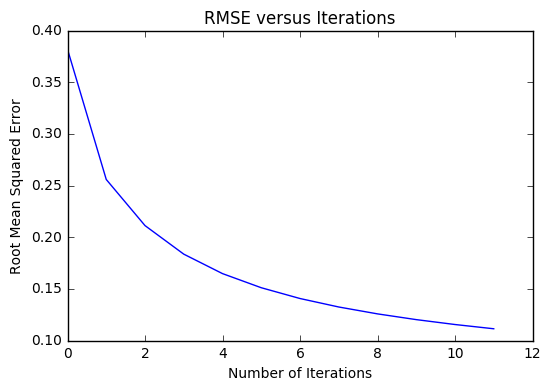

In [41]:
# plot the root mean squared errors versus number of iterations
plt.plot(test_rmses);
plt.title('RMSE versus Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Root Mean Squared Error')
plt.savefig('rmse.png')

Write some of the final results into files to be used for a written report.

In [42]:
%%writefile test_rmses
test_rmses

Overwriting test_rmses


In [43]:
test_rmses

[0.38184014585486925,
 0.2558363838229086,
 0.21120390267050546,
 0.18357566002361322,
 0.16473267023673333,
 0.15107193527981697,
 0.14062965199708835,
 0.1324262960746408,
 0.12576337077857377,
 0.12020498401860374,
 0.11546513578795456,
 0.1113532716382039]

In [44]:
%%writefile train_errors_list
train_errors_list

Overwriting train_errors_list


In [45]:
train_errors_list

{0: {(10, 0.01): [0.6207392673837988,
   0.5487874871608881,
   0.5182631663114508,
   0.5003310719477485,
   0.4879214451661268,
   0.47887913929185283,
   0.47211249468337246,
   0.46691777711228916,
   0.46279148871852926,
   0.4593752254064025,
   0.4564603345230242,
   0.45392793225365824],
  (10, 0.1): [0.7602074846180296,
   0.6142457118130422,
   0.5608801238918207,
   0.5331677148850701,
   0.5159568814909723,
   0.5040375847136245,
   0.4952531267141039,
   0.4885089278662767,
   0.4831541353259242,
   0.47877063334806835,
   0.475078282994288,
   0.4719123056575188],
  (10, 1): [1.3590688368165558,
   0.8276240832196143,
   0.7049110985420213,
   0.6433323126054715,
   0.6036933753727607,
   0.5767515774614221,
   0.5575287549487183,
   0.5432344517236779,
   0.532158084332534,
   0.5233115287954497,
   0.5161268059577786,
   0.5101930130298808],
  (13, 0.01): [0.5883664594264071,
   0.511800368108893,
   0.47814912790924896,
   0.45785458216247005,
   0.4433858568839944,
  

In [46]:
%%writefile val_errors
val_errors

Overwriting val_errors


In [47]:
val_errors

{0: [0.44187657971522604,
  0.2743703871025651,
  0.22630041651000407,
  0.19741593471695518,
  0.17779109784405184,
  0.16332371808955432,
  0.15203698208763555,
  0.1429313514696443,
  0.13545171949689128,
  0.12921119681672213,
  0.12392114379401133,
  0.11936594799632551],
 1: [0.38502403049444456,
  0.27187147692347347,
  0.2307206318250529,
  0.20593540960749782,
  0.18898367405654404,
  0.17608496350457745,
  0.16563081110357722,
  0.15707613496766368,
  0.15007527715956268,
  0.14429838555204857,
  0.13947136667188711,
  0.13536666278445095],
 2: [0.39612831487288885,
  0.26988116933741907,
  0.22636149092996705,
  0.200593765086749,
  0.18268755859124952,
  0.16921210122592328,
  0.1585861466867265,
  0.14996638786564398,
  0.14285651323898294,
  0.13692715088649576,
  0.1319312344086906,
  0.1276766036042474],
 3: [0.40069839670278123,
  0.2749496024563838,
  0.22831521616876996,
  0.2005680108579301,
  0.1820474720360778,
  0.16865174829720736,
  0.15834075955709703,
  0.150

## Use Test Run Results to Print Recommendations

In [48]:
# initialize year for the year at which you initially define recent releases(releases that occured > year specified)
# if no recent releases with "good" ratings are found within that range, the program will decrease the year until one is found
year = 2012
make_recommendation(Q, W, X, Y, test_set_pt, movies_links, year)

userId: 1.0:
 Top Rated Movie was: Tron (1982).
 Top Recommended Movie is: Ghost (1990).
 Link: http://www.imdb.com/title/tt99653/
 Top Recommended Recent Release Movie is: Frozen (2013).
 Link: http://www.imdb.com/title/tt2294629/

userId: 4.0:
 Top Rated Movie was: Hard-Boiled (Lat sau san taam) (1992).
 Top Recommended Movie is: 2001: A Space Odyssey (1968).
 Link: http://www.imdb.com/title/tt62622/
 Top Recommended Recent Release Movie is: Argo (2012).
 Link: http://www.imdb.com/title/tt1024648/

userId: 5.0:
 Top Rated Movie was: Crash (2004).
 Top Recommended Movie is: Four Weddings and a Funeral (1994).
 Link: http://www.imdb.com/title/tt109831/
 Top Recommended Recent Release Movie is: Grand Budapest Hotel, The (2014).
 Link: http://www.imdb.com/title/tt2278388/

userId: 12.0:
 Top Rated Movie was: Art of War, The (2000).
 Top Recommended Movie is: Some Like It Hot (1959).
 Link: http://www.imdb.com/title/tt53291/
 Top Recommended Recent Release Movie is: Royal Affair, A (Konge